# CIC-IDS2017 EDA - Notebook 3: Target Analysis

In [1]:
# =============================================================================
# IMPORTS
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import warnings
from scipy import stats
from datetime import datetime
from collections import defaultdict

warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Plot settings
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
sns.set_style('whitegrid')

print(f"Phase 4-5 Analysis started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Phase 4-5 Analysis started: 2025-12-23 18:39:02


In [2]:
# =============================================================================
# LOAD DATA AND PHASE 3 OUTPUTS
# =============================================================================

OUTPUT_DIR = "eda_outputs/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load global sample
sample_path = os.path.join(OUTPUT_DIR, 'global_sample.csv')
print(f"Loading: {sample_path}")
df = pd.read_csv(sample_path, low_memory=False)
print(f"Dataset shape: {df.shape[0]:,} rows × {df.shape[1]} columns")

# Load transform plan from Phase 3
transform_path = os.path.join(OUTPUT_DIR, 'preliminary_transform_plan.json')
if os.path.exists(transform_path):
    with open(transform_path, 'r') as f:
        transform_plan = json.load(f)
    print(f"✓ Loaded transform plan from Phase 3")
else:
    transform_plan = None
    print("⚠ No transform plan found")

# Load data quality issues
quality_path = os.path.join(OUTPUT_DIR, 'data_quality_issues.json')
if os.path.exists(quality_path):
    with open(quality_path, 'r') as f:
        data_quality = json.load(f)
    print(f"✓ Loaded data quality issues")
else:
    data_quality = {}
    print("⚠ No data quality file found")

Loading: eda_outputs/global_sample.csv
Dataset shape: 283,138 rows × 87 columns
✓ Loaded transform plan from Phase 3
✓ Loaded data quality issues


In [3]:
# =============================================================================
# DEFINE FEATURE SETS
# =============================================================================

# Target column
TARGET_COL = 'Label'

# Columns to exclude from feature analysis
EXCLUDE_COLS = {'Flow ID', 'Source IP', 'Destination IP', 'Timestamp',
                'Label', 'Is_Attack', 'Attack_Family', 'Source_File'}

# Categorical columns
CATEGORICAL_COLS = {'Protocol', 'Destination Port'}

# Get features to drop (from Phase 3)
if transform_plan:
    DROP_FEATURES = set(transform_plan.get('drop', []))
else:
    DROP_FEATURES = set()

# Get usable numerical features
all_cols = set(df.columns)
numerical_features = []

for col in df.columns:
    if col in EXCLUDE_COLS:
        continue
    if col in CATEGORICAL_COLS:
        continue
    if col in DROP_FEATURES:
        continue
    if df[col].dtype in ['int64', 'int32', 'float64', 'float32']:
        numerical_features.append(col)

numerical_features = sorted(numerical_features)

print(f"\nFeature sets:")
print(f"  Total columns: {len(all_cols)}")
print(f"  Excluded (identifiers/targets): {len(EXCLUDE_COLS & all_cols)}")
print(f"  Dropped (zero variance): {len(DROP_FEATURES)}")
print(f"  Categorical: {len(CATEGORICAL_COLS)}")
print(f"  Numerical features for analysis: {len(numerical_features)}")


Feature sets:
  Total columns: 87
  Excluded (identifiers/targets): 8
  Dropped (zero variance): 12
  Categorical: 2
  Numerical features for analysis: 65


In [4]:
# =============================================================================
# CREATE TARGET COLUMNS
# =============================================================================

# Check if Label column exists
if TARGET_COL not in df.columns:
    raise ValueError(f"Target column '{TARGET_COL}' not found in dataset")

# Create binary target: Is_Attack
if 'Is_Attack' not in df.columns:
    df['Is_Attack'] = (df[TARGET_COL] != 'BENIGN').astype(int)
    print("✓ Created Is_Attack column")

# Define attack families (grouping similar attacks)
ATTACK_FAMILIES = {
    'BENIGN': 'BENIGN',
    'FTP-Patator': 'Brute Force',
    'SSH-Patator': 'Brute Force',
    'DoS slowloris': 'DoS',
    'DoS Slowhttptest': 'DoS',
    'DoS Hulk': 'DoS',
    'DoS GoldenEye': 'DoS',
    'Heartbleed': 'Heartbleed',
    'Web Attack � Brute Force': 'Web Attack',
    'Web Attack � XSS': 'Web Attack',
    'Web Attack � Sql Injection': 'Web Attack',
    'Infiltration': 'Infiltration',
    'Bot': 'Botnet',
    'PortScan': 'Reconnaissance',
    'DDoS': 'DDoS',
}

# Create Attack_Family column
if 'Attack_Family' not in df.columns:
    df['Attack_Family'] = df[TARGET_COL].map(ATTACK_FAMILIES)
    # Handle any unmapped labels
    unmapped = df['Attack_Family'].isna().sum()
    if unmapped > 0:
        print(f"⚠ {unmapped} rows have unmapped labels")
        # Fill with original label
        df['Attack_Family'] = df['Attack_Family'].fillna(df[TARGET_COL])
    print("✓ Created Attack_Family column")

print(f"\nTarget columns available:")
print(f"  - Label (original): {df[TARGET_COL].nunique()} classes")
print(f"  - Is_Attack (binary): 2 classes")
print(f"  - Attack_Family (grouped): {df['Attack_Family'].nunique()} families")


Target columns available:
  - Label (original): 15 classes
  - Is_Attack (binary): 2 classes
  - Attack_Family (grouped): 8 families


---
# Phase 4: Target Variable Analysis

In [5]:
# =============================================================================
# 4.1: BINARY CLASSIFICATION - BENIGN vs ATTACK
# =============================================================================

print("=" * 70)
print("4.1: BINARY CLASSIFICATION - BENIGN vs ATTACK")
print("=" * 70)

binary_counts = df['Is_Attack'].value_counts().sort_index()
binary_pcts = df['Is_Attack'].value_counts(normalize=True).sort_index() * 100

print("\n--- Class Distribution ---")
print(f"  BENIGN (0): {binary_counts[0]:,} ({binary_pcts[0]:.2f}%)")
print(f"  ATTACK (1): {binary_counts[1]:,} ({binary_pcts[1]:.2f}%)")

# Imbalance ratio
imbalance_ratio = binary_counts.max() / binary_counts.min()
print(f"\n--- Imbalance Metrics ---")
print(f"  Imbalance Ratio: {imbalance_ratio:.2f}:1")
print(f"  Minority class: {'BENIGN' if binary_counts[0] < binary_counts[1] else 'ATTACK'}")

# Assessment
if imbalance_ratio < 1.5:
    balance_status = "Well-balanced"
elif imbalance_ratio < 3:
    balance_status = "Slightly imbalanced"
elif imbalance_ratio < 10:
    balance_status = "Moderately imbalanced"
else:
    balance_status = "Highly imbalanced"

print(f"  Status: {balance_status}")

# Store for later
BINARY_STATS = {
    'benign_count': int(binary_counts[0]),
    'attack_count': int(binary_counts[1]),
    'benign_pct': float(binary_pcts[0]),
    'attack_pct': float(binary_pcts[1]),
    'imbalance_ratio': float(imbalance_ratio),
    'balance_status': balance_status,
}

4.1: BINARY CLASSIFICATION - BENIGN vs ATTACK

--- Class Distribution ---
  BENIGN (0): 227,311 (80.28%)
  ATTACK (1): 55,827 (19.72%)

--- Imbalance Metrics ---
  Imbalance Ratio: 4.07:1
  Minority class: ATTACK
  Status: Moderately imbalanced


In [6]:
# =============================================================================
# 4.2: MULTI-CLASS - ALL 15 LABELS
# =============================================================================

print("=" * 70)
print("4.2: MULTI-CLASS - ALL LABELS")
print("=" * 70)

label_counts = df[TARGET_COL].value_counts()
label_pcts = df[TARGET_COL].value_counts(normalize=True) * 100

print(f"\n--- Class Distribution ({len(label_counts)} classes) ---\n")
print(f"{'Label':<35} {'Count':>12} {'Percent':>10}")
print("-" * 60)

for label in label_counts.index:
    count = label_counts[label]
    pct = label_pcts[label]
    bar = '█' * int(pct / 2)  # Visual bar
    print(f"{label:<35} {count:>12,} {pct:>9.2f}% {bar}")

# Identify rare classes
rare_threshold = 1.0  # Less than 1%
rare_classes = label_pcts[label_pcts < rare_threshold]

print(f"\n--- Rare Classes (<{rare_threshold}%) ---")
if len(rare_classes) > 0:
    for label, pct in rare_classes.items():
        print(f"  {label}: {pct:.3f}% ({label_counts[label]:,} samples)")
    print(f"\n  ⚠ {len(rare_classes)} rare classes may need oversampling or special handling")
else:
    print("  ✓ No rare classes")

# Store
MULTICLASS_STATS = {
    'n_classes': len(label_counts),
    'class_counts': label_counts.to_dict(),
    'class_pcts': label_pcts.to_dict(),
    'rare_classes': rare_classes.index.tolist(),
    'max_class': label_counts.idxmax(),
    'min_class': label_counts.idxmin(),
    'max_min_ratio': float(label_counts.max() / label_counts.min()),
}

4.2: MULTI-CLASS - ALL LABELS

--- Class Distribution (15 classes) ---

Label                                      Count    Percent
------------------------------------------------------------
BENIGN                                   227,311     80.28% ████████████████████████████████████████
DoS Hulk                                  23,107      8.16% ████
PortScan                                  15,893      5.61% ██
DDoS                                      12,803      4.52% ██
DoS GoldenEye                              1,029      0.36% 
FTP-Patator                                  794      0.28% 
SSH-Patator                                  590      0.21% 
DoS Slowloris                                580      0.20% 
DoS Slowhttptest                             550      0.19% 
Bot                                          197      0.07% 
Web Attack - Brute Force                     151      0.05% 
Web Attack - XSS                              65      0.02% 
Infiltration               

In [7]:
# =============================================================================
# 4.3: ATTACK FAMILIES
# =============================================================================

print("=" * 70)
print("4.3: ATTACK FAMILIES (Grouped)")
print("=" * 70)

family_counts = df['Attack_Family'].value_counts()
family_pcts = df['Attack_Family'].value_counts(normalize=True) * 100

print(f"\n--- Family Distribution ({len(family_counts)} families) ---\n")
print(f"{'Family':<20} {'Count':>12} {'Percent':>10} {'Labels Included'}")
print("-" * 80)

# Get labels in each family
family_to_labels = defaultdict(list)
for label, family in ATTACK_FAMILIES.items():
    family_to_labels[family].append(label)

for family in family_counts.index:
    count = family_counts[family]
    pct = family_pcts[family]
    labels = family_to_labels.get(family, [family])
    labels_str = ', '.join(labels[:3])
    if len(labels) > 3:
        labels_str += f" (+{len(labels)-3} more)"
    print(f"{family:<20} {count:>12,} {pct:>9.2f}%  {labels_str}")

# Attack-only families (excluding BENIGN)
attack_families = df[df['Is_Attack'] == 1]['Attack_Family'].value_counts()
print(f"\n--- Attack-Only Distribution ---")
attack_family_pcts = attack_families / attack_families.sum() * 100
for family, count in attack_families.items():
    pct = attack_family_pcts[family]
    print(f"  {family}: {count:,} ({pct:.1f}% of attacks)")

FAMILY_STATS = {
    'n_families': len(family_counts),
    'family_counts': family_counts.to_dict(),
    'family_pcts': family_pcts.to_dict(),
    'family_to_labels': dict(family_to_labels),
}

4.3: ATTACK FAMILIES (Grouped)

--- Family Distribution (8 families) ---

Family                      Count    Percent Labels Included
--------------------------------------------------------------------------------
BENIGN                    227,311     80.28%  BENIGN
DoS                        38,069     13.45%  DoS slowloris, DoS Slowhttptest, DoS Hulk (+1 more)
Probe                      15,893      5.61%  Probe
BruteForce                  1,384      0.49%  BruteForce
WebAttack                     237      0.08%  WebAttack
Botnet                        197      0.07%  Bot
Infiltration                   36      0.01%  Infiltration
Heartbleed                     11      0.00%  Heartbleed

--- Attack-Only Distribution ---
  DoS: 38,069 (68.2% of attacks)
  Probe: 15,893 (28.5% of attacks)
  BruteForce: 1,384 (2.5% of attacks)
  WebAttack: 237 (0.4% of attacks)
  Botnet: 197 (0.4% of attacks)
  Infiltration: 36 (0.1% of attacks)
  Heartbleed: 11 (0.0% of attacks)


In [8]:
# =============================================================================
# 4.4: CLASS IMBALANCE ASSESSMENT
# =============================================================================

print("=" * 70)
print("4.4: CLASS IMBALANCE ASSESSMENT")
print("=" * 70)

print("\n--- Summary by Classification Level ---\n")

# Binary
print(f"Binary (BENIGN vs ATTACK):")
print(f"  Classes: 2")
print(f"  Imbalance ratio: {BINARY_STATS['imbalance_ratio']:.2f}:1")
print(f"  Status: {BINARY_STATS['balance_status']}")
if BINARY_STATS['imbalance_ratio'] > 3:
    print(f"  → Recommendation: Use stratified sampling, consider class weights")
else:
    print(f"  → Recommendation: Standard train/test split with stratification")

# Multi-class
print(f"\nMulti-class (all {MULTICLASS_STATS['n_classes']} labels):")
print(f"  Max/Min ratio: {MULTICLASS_STATS['max_min_ratio']:.1f}:1")
print(f"  Largest class: {MULTICLASS_STATS['max_class']} ({label_pcts[MULTICLASS_STATS['max_class']]:.1f}%)")
print(f"  Smallest class: {MULTICLASS_STATS['min_class']} ({label_pcts[MULTICLASS_STATS['min_class']]:.3f}%)")
print(f"  Rare classes (<1%): {len(MULTICLASS_STATS['rare_classes'])}")

if MULTICLASS_STATS['max_min_ratio'] > 100:
    print(f"  → Recommendation: SMOTE/ADASYN for rare classes, or use hierarchical classification")
elif MULTICLASS_STATS['max_min_ratio'] > 10:
    print(f"  → Recommendation: Class weights or oversampling for minority classes")

# Attack families
print(f"\nAttack Families ({FAMILY_STATS['n_families']} families):")
family_ratio = max(family_counts) / min(family_counts)
print(f"  Max/Min ratio: {family_ratio:.1f}:1")
print(f"  → Grouping reduces imbalance compared to 15-class problem")

# Recommendations
print("\n--- Modeling Recommendations ---")
print("""
1. Binary Classification (Primary Task):
   - Use stratified K-fold cross-validation
   - Evaluate with: F1, Precision, Recall, ROC-AUC, PR-AUC
   - Class weights may not be necessary given moderate imbalance

2. Multi-class Classification:
   - Consider hierarchical approach: Binary → Family → Specific
   - Use macro/weighted F1 for evaluation
   - Apply SMOTE to rare classes (Heartbleed, Web Attacks, Infiltration)

3. Attack Family Classification:
   - Good intermediate task
   - 8 classes is more manageable than 15
   - Still captures attack semantics
""")

4.4: CLASS IMBALANCE ASSESSMENT

--- Summary by Classification Level ---

Binary (BENIGN vs ATTACK):
  Classes: 2
  Imbalance ratio: 4.07:1
  Status: Moderately imbalanced
  → Recommendation: Use stratified sampling, consider class weights

Multi-class (all 15 labels):
  Max/Min ratio: 20664.6:1
  Largest class: BENIGN (80.3%)
  Smallest class: Heartbleed (0.004%)
  Rare classes (<1%): 11
  → Recommendation: SMOTE/ADASYN for rare classes, or use hierarchical classification

Attack Families (8 families):
  Max/Min ratio: 20664.6:1
  → Grouping reduces imbalance compared to 15-class problem

--- Modeling Recommendations ---

1. Binary Classification (Primary Task):
   - Use stratified K-fold cross-validation
   - Evaluate with: F1, Precision, Recall, ROC-AUC, PR-AUC
   - Class weights may not be necessary given moderate imbalance

2. Multi-class Classification:
   - Consider hierarchical approach: Binary → Family → Specific
   - Use macro/weighted F1 for evaluation
   - Apply SMOTE to ra

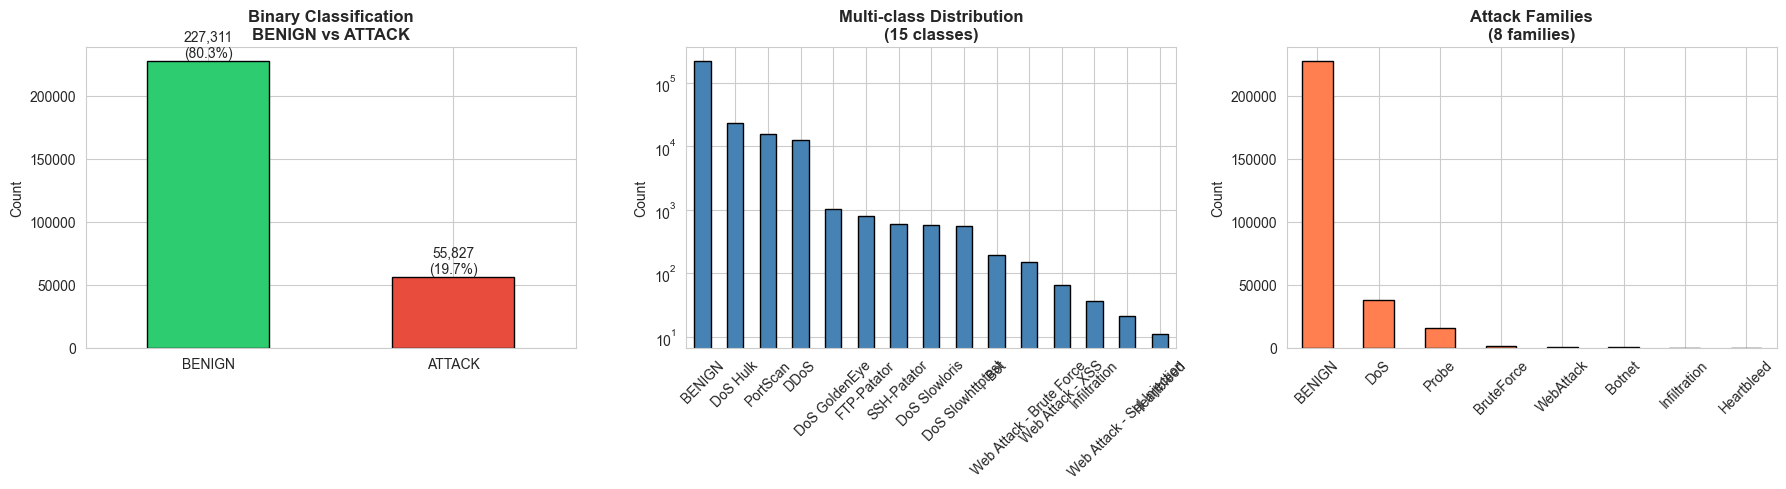

✓ Saved: target_distributions.png


In [9]:
# =============================================================================
# TARGET DISTRIBUTION VISUALIZATIONS
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Binary
ax1 = axes[0]
colors = ['#2ecc71', '#e74c3c']
binary_counts.plot(kind='bar', ax=ax1, color=colors, edgecolor='black')
ax1.set_title('Binary Classification\nBENIGN vs ATTACK', fontsize=12, fontweight='bold')
ax1.set_xlabel('')
ax1.set_ylabel('Count')
ax1.set_xticklabels(['BENIGN', 'ATTACK'], rotation=0)
for i, (idx, val) in enumerate(binary_counts.items()):
    ax1.text(i, val + 1000, f'{val:,}\n({binary_pcts[idx]:.1f}%)', 
             ha='center', va='bottom', fontsize=10)

# Multi-class
ax2 = axes[1]
label_counts.plot(kind='bar', ax=ax2, color='steelblue', edgecolor='black')
ax2.set_title(f'Multi-class Distribution\n({len(label_counts)} classes)', fontsize=12, fontweight='bold')
ax2.set_xlabel('')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=45)
ax2.set_yscale('log')  # Log scale due to imbalance

# Attack Families
ax3 = axes[2]
family_counts.plot(kind='bar', ax=ax3, color='coral', edgecolor='black')
ax3.set_title(f'Attack Families\n({len(family_counts)} families)', fontsize=12, fontweight='bold')
ax3.set_xlabel('')
ax3.set_ylabel('Count')
ax3.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'target_distributions.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Saved: target_distributions.png")

---
# Phase 5: Feature-Target Relationships

Which features best discriminate between classes?

In [10]:
# =============================================================================
# STATISTICAL TEST HELPER FUNCTIONS
# =============================================================================

def cliffs_delta(x, y):
    """
    Compute Cliff's Delta effect size for two groups.
    Returns value in [-1, 1] where:
    - |d| < 0.147: negligible
    - |d| < 0.33: small
    - |d| < 0.474: medium
    - |d| >= 0.474: large
    """
    n_x, n_y = len(x), len(y)
    if n_x == 0 or n_y == 0:
        return 0.0
    
    # Efficient computation using ranks
    # Count pairs where x > y, x < y
    more = 0
    less = 0
    
    # Sample if too large
    max_samples = 10000
    if n_x > max_samples:
        x = np.random.choice(x, max_samples, replace=False)
        n_x = max_samples
    if n_y > max_samples:
        y = np.random.choice(y, max_samples, replace=False)
        n_y = max_samples
    
    for xi in x:
        more += np.sum(xi > y)
        less += np.sum(xi < y)
    
    delta = (more - less) / (n_x * n_y)
    return delta

def interpret_cliffs_delta(d):
    """Interpret Cliff's Delta magnitude."""
    d = abs(d)
    if d < 0.147:
        return 'negligible'
    elif d < 0.33:
        return 'small'
    elif d < 0.474:
        return 'medium'
    else:
        return 'large'

def eta_squared(h_stat, n_groups, n_total):
    """
    Compute Eta-squared effect size from Kruskal-Wallis H statistic.
    η² = (H - k + 1) / (n - k)
    """
    eta_sq = (h_stat - n_groups + 1) / (n_total - n_groups)
    return max(0, eta_sq)  # Clamp to 0

def interpret_eta_squared(eta):
    """Interpret Eta-squared magnitude."""
    if eta < 0.01:
        return 'negligible'
    elif eta < 0.06:
        return 'small'
    elif eta < 0.14:
        return 'medium'
    else:
        return 'large'

def get_clean_feature_data(series):
    """Get clean feature data, excluding inf and -1 sentinel."""
    clean = series.replace([np.inf, -np.inf], np.nan)
    clean = clean[clean != -1]  # Exclude sentinel
    return clean.dropna()

print("✓ Helper functions defined")

✓ Helper functions defined


In [11]:
# =============================================================================
# 5.1: BINARY DISCRIMINATION (Mann-Whitney U Test)
# =============================================================================

print("=" * 70)
print("5.1: BINARY DISCRIMINATION (Mann-Whitney U Test)")
print("=" * 70)
print("\nTesting each feature's ability to distinguish BENIGN vs ATTACK...\n")

# Get indices for each class
benign_idx = df['Is_Attack'] == 0
attack_idx = df['Is_Attack'] == 1

binary_results = []

for i, feature in enumerate(numerical_features):
    if (i + 1) % 20 == 0:
        print(f"  Progress: {i + 1}/{len(numerical_features)}")
    
    # Get data for each class
    benign_data = get_clean_feature_data(df.loc[benign_idx, feature])
    attack_data = get_clean_feature_data(df.loc[attack_idx, feature])
    
    # Skip if insufficient data
    if len(benign_data) < 10 or len(attack_data) < 10:
        binary_results.append({
            'feature': feature,
            'u_statistic': np.nan,
            'p_value': np.nan,
            'cliffs_delta': np.nan,
            'effect_size': 'insufficient_data',
            'benign_median': np.nan,
            'attack_median': np.nan,
            'significant': False,
        })
        continue
    
    # Mann-Whitney U test
    try:
        u_stat, p_value = stats.mannwhitneyu(benign_data, attack_data, alternative='two-sided')
    except Exception as e:
        u_stat, p_value = np.nan, np.nan
    
    # Cliff's Delta effect size
    try:
        delta = cliffs_delta(benign_data.values, attack_data.values)
    except:
        delta = np.nan
    
    effect_size = interpret_cliffs_delta(delta) if not pd.isna(delta) else 'unknown'
    
    binary_results.append({
        'feature': feature,
        'u_statistic': u_stat,
        'p_value': p_value,
        'cliffs_delta': delta,
        'effect_size': effect_size,
        'benign_median': benign_data.median(),
        'attack_median': attack_data.median(),
        'significant': p_value < 0.05 if not pd.isna(p_value) else False,
    })

df_binary_disc = pd.DataFrame(binary_results).set_index('feature')

# Sort by effect size (absolute Cliff's Delta)
df_binary_disc['abs_delta'] = df_binary_disc['cliffs_delta'].abs()
df_binary_disc = df_binary_disc.sort_values('abs_delta', ascending=False)

print(f"\n✓ Tested {len(numerical_features)} features")
print(f"  Significant (p<0.05): {df_binary_disc['significant'].sum()}")
print(f"  Large effect: {(df_binary_disc['effect_size'] == 'large').sum()}")
print(f"  Medium effect: {(df_binary_disc['effect_size'] == 'medium').sum()}")
print(f"  Small effect: {(df_binary_disc['effect_size'] == 'small').sum()}")

5.1: BINARY DISCRIMINATION (Mann-Whitney U Test)

Testing each feature's ability to distinguish BENIGN vs ATTACK...

  Progress: 20/65
  Progress: 40/65
  Progress: 60/65

✓ Tested 65 features
  Significant (p<0.05): 65
  Large effect: 2
  Medium effect: 2
  Small effect: 23


In [12]:
# Show top discriminating features for binary classification
print("\n--- Top 20 Discriminating Features (Binary) ---\n")
print(f"{'Feature':<35} {'Cliff Delta':>12} {'Effect':>10} {'BENIGN Med':>12} {'ATTACK Med':>12}")
print("-" * 85)

for feat, row in df_binary_disc.head(20).iterrows():
    delta = row['cliffs_delta']
    effect = row['effect_size']
    b_med = row['benign_median']
    a_med = row['attack_median']
    
    # Direction indicator
    direction = '↑' if delta > 0 else '↓'  # ↑ = higher in benign
    
    if pd.notna(delta):
        print(f"{feat:<35} {delta:>+11.3f}{direction} {effect:>10} {b_med:>12.2f} {a_med:>12.2f}")
    else:
        print(f"{feat:<35} {'N/A':>12} {effect:>10}")

print("\n  ↑ = higher in BENIGN | ↓ = higher in ATTACK")


--- Top 20 Discriminating Features (Binary) ---

Feature                              Cliff Delta     Effect   BENIGN Med   ATTACK Med
-------------------------------------------------------------------------------------
Min Packet Length                        +0.489↑      large         6.00         0.00
Fwd Packet Length Min                    +0.483↑      large         6.00         0.00
Init_Win_bytes_backward                  +0.436↑     medium       256.00       229.00
Bwd Packet Length Min                    +0.386↑     medium         6.00         0.00
Fwd Packet Length Mean                   +0.317↑      small        37.00         6.00
Fwd IAT Std                              -0.315↓      small         0.00      1815.85
Bwd Packet Length Std                    -0.313↓      small         0.00         0.00
Avg Fwd Segment Size                     +0.301↑      small        37.00         6.00
Fwd Packet Length Max                    +0.287↑      small        40.00         6.00
Tota

In [13]:
# =============================================================================
# 5.2: MULTI-CLASS DISCRIMINATION (Kruskal-Wallis H Test)
# =============================================================================

print("=" * 70)
print("5.2: MULTI-CLASS DISCRIMINATION (Kruskal-Wallis H Test)")
print("=" * 70)
print("\nTesting each feature's ability to distinguish among all attack types...\n")

# Get unique labels
unique_labels = df[TARGET_COL].unique()
n_classes = len(unique_labels)

multiclass_results = []

for i, feature in enumerate(numerical_features):
    if (i + 1) % 20 == 0:
        print(f"  Progress: {i + 1}/{len(numerical_features)}")
    
    # Get data for each class
    groups = []
    for label in unique_labels:
        group_data = get_clean_feature_data(df.loc[df[TARGET_COL] == label, feature])
        if len(group_data) >= 5:  # Need at least 5 samples
            groups.append(group_data.values)
    
    # Skip if not enough groups
    if len(groups) < 2:
        multiclass_results.append({
            'feature': feature,
            'h_statistic': np.nan,
            'p_value': np.nan,
            'eta_squared': np.nan,
            'effect_size': 'insufficient_data',
            'n_groups': len(groups),
            'significant': False,
        })
        continue
    
    # Kruskal-Wallis H test
    try:
        h_stat, p_value = stats.kruskal(*groups)
    except Exception as e:
        h_stat, p_value = np.nan, np.nan
    
    # Eta-squared effect size
    n_total = sum(len(g) for g in groups)
    if not pd.isna(h_stat):
        eta_sq = eta_squared(h_stat, len(groups), n_total)
    else:
        eta_sq = np.nan
    
    effect = interpret_eta_squared(eta_sq) if not pd.isna(eta_sq) else 'unknown'
    
    multiclass_results.append({
        'feature': feature,
        'h_statistic': h_stat,
        'p_value': p_value,
        'eta_squared': eta_sq,
        'effect_size': effect,
        'n_groups': len(groups),
        'significant': p_value < 0.05 if not pd.isna(p_value) else False,
    })

df_multi_disc = pd.DataFrame(multiclass_results).set_index('feature')
df_multi_disc = df_multi_disc.sort_values('eta_squared', ascending=False)

print(f"\n✓ Tested {len(numerical_features)} features")
print(f"  Significant (p<0.05): {df_multi_disc['significant'].sum()}")
print(f"  Large effect (η²≥0.14): {(df_multi_disc['effect_size'] == 'large').sum()}")
print(f"  Medium effect (η²≥0.06): {(df_multi_disc['effect_size'] == 'medium').sum()}")

5.2: MULTI-CLASS DISCRIMINATION (Kruskal-Wallis H Test)

Testing each feature's ability to distinguish among all attack types...

  Progress: 20/65
  Progress: 40/65
  Progress: 60/65

✓ Tested 65 features
  Significant (p<0.05): 65
  Large effect (η²≥0.14): 21
  Medium effect (η²≥0.06): 36


In [14]:
# Show top discriminating features for multi-class
print("\n--- Top 20 Discriminating Features (Multi-class) ---\n")
print(f"{'Feature':<40} {'H-stat':>12} {'η²':>10} {'Effect':>12} {'p-value':>12}")
print("-" * 90)

for feat, row in df_multi_disc.head(20).iterrows():
    h = row['h_statistic']
    eta = row['eta_squared']
    effect = row['effect_size']
    p = row['p_value']
    
    if pd.notna(h):
        p_str = f"{p:.2e}" if p < 0.001 else f"{p:.4f}"
        print(f"{feat:<40} {h:>12.1f} {eta:>10.4f} {effect:>12} {p_str:>12}")
    else:
        print(f"{feat:<40} {'N/A':>12}")


--- Top 20 Discriminating Features (Multi-class) ---

Feature                                        H-stat         η²       Effect      p-value
------------------------------------------------------------------------------------------
Init_Win_bytes_backward                       37584.3     0.2710        large     0.00e+00
Bwd Packets/s                                 66150.6     0.2336        large     0.00e+00
Fwd IAT Max                                   62852.0     0.2219        large     0.00e+00
Fwd IAT Mean                                  61630.5     0.2176        large     0.00e+00
Fwd IAT Total                                 57319.2     0.2024        large     0.00e+00
Bwd Packet Length Std                         55172.5     0.1948        large     0.00e+00
Fwd IAT Std                                   53670.1     0.1895        large     0.00e+00
Total Fwd Packets                             49981.5     0.1765        large     0.00e+00
Subflow Fwd Packets                

In [15]:
# =============================================================================
# 5.3: COMBINED FEATURE RANKING
# =============================================================================

print("=" * 70)
print("5.3: COMBINED FEATURE RANKING")
print("=" * 70)

# Combine binary and multi-class results
df_ranking = pd.DataFrame(index=numerical_features)

# Add binary discrimination
df_ranking['binary_delta'] = df_binary_disc['cliffs_delta'].abs()
df_ranking['binary_effect'] = df_binary_disc['effect_size']
df_ranking['binary_significant'] = df_binary_disc['significant']

# Add multi-class discrimination
df_ranking['multi_eta'] = df_multi_disc['eta_squared']
df_ranking['multi_effect'] = df_multi_disc['effect_size']
df_ranking['multi_significant'] = df_multi_disc['significant']

# Compute combined score (normalize and average)
# Normalize to 0-1 range
delta_max = df_ranking['binary_delta'].max()
eta_max = df_ranking['multi_eta'].max()

if delta_max > 0:
    df_ranking['binary_score'] = df_ranking['binary_delta'] / delta_max
else:
    df_ranking['binary_score'] = 0

if eta_max > 0:
    df_ranking['multi_score'] = df_ranking['multi_eta'] / eta_max
else:
    df_ranking['multi_score'] = 0

# Fill NaN with 0
df_ranking['binary_score'] = df_ranking['binary_score'].fillna(0)
df_ranking['multi_score'] = df_ranking['multi_score'].fillna(0)

# Combined score (equal weight)
df_ranking['combined_score'] = (df_ranking['binary_score'] + df_ranking['multi_score']) / 2

# Rank features
df_ranking = df_ranking.sort_values('combined_score', ascending=False)
df_ranking['rank'] = range(1, len(df_ranking) + 1)

print("\n--- Top 25 Features by Combined Discriminative Power ---\n")
print(f"{'Rank':>4} {'Feature':<35} {'Binary Δ':>10} {'Multi η²':>10} {'Combined':>10}")
print("-" * 75)

for feat, row in df_ranking.head(25).iterrows():
    rank = int(row['rank'])
    b_delta = row['binary_delta']
    m_eta = row['multi_eta']
    combined = row['combined_score']
    
    b_str = f"{b_delta:.3f}" if pd.notna(b_delta) else "N/A"
    m_str = f"{m_eta:.4f}" if pd.notna(m_eta) else "N/A"
    
    print(f"{rank:>4} {feat:<35} {b_str:>10} {m_str:>10} {combined:>10.3f}")

# Identify tiers
top_tier = df_ranking[df_ranking['combined_score'] >= 0.5].index.tolist()
mid_tier = df_ranking[(df_ranking['combined_score'] >= 0.2) & 
                      (df_ranking['combined_score'] < 0.5)].index.tolist()
low_tier = df_ranking[df_ranking['combined_score'] < 0.2].index.tolist()

print(f"\n--- Feature Tiers ---")
print(f"  Top tier (≥0.5): {len(top_tier)} features")
print(f"  Mid tier (0.2-0.5): {len(mid_tier)} features")
print(f"  Low tier (<0.2): {len(low_tier)} features")

5.3: COMBINED FEATURE RANKING

--- Top 25 Features by Combined Discriminative Power ---

Rank Feature                               Binary Δ   Multi η²   Combined
---------------------------------------------------------------------------
   1 Init_Win_bytes_backward                  0.436     0.2710      0.945
   2 Min Packet Length                        0.489     0.1370      0.753
   3 Fwd Packet Length Min                    0.483     0.1330      0.739
   4 Bwd Packet Length Std                    0.313     0.1948      0.679
   5 Fwd IAT Std                              0.315     0.1895      0.672
   6 Bwd Packet Length Min                    0.386     0.1370      0.648
   7 Fwd IAT Max                              0.208     0.2219      0.622
   8 Fwd IAT Mean                             0.198     0.2176      0.604
   9 Bwd Packets/s                            0.155     0.2336      0.589
  10 Idle Max                                 0.262     0.1722      0.585
  11 Idle Mean       

In [16]:
# =============================================================================
# 5.4: ATTACK-SPECIFIC FEATURE SIGNATURES
# =============================================================================

print("=" * 70)
print("5.4: ATTACK-SPECIFIC FEATURE SIGNATURES")
print("=" * 70)
print("\nWhich features are most distinctive for each attack type?\n")

# Use top 10 features for signature analysis
top_features = df_ranking.head(10).index.tolist()

# Compute median values for each attack type
attack_signatures = {}

for label in df[TARGET_COL].unique():
    label_data = df[df[TARGET_COL] == label]
    signature = {}
    
    for feat in top_features:
        clean_data = get_clean_feature_data(label_data[feat])
        if len(clean_data) > 0:
            signature[feat] = clean_data.median()
        else:
            signature[feat] = np.nan
    
    attack_signatures[label] = signature

df_signatures = pd.DataFrame(attack_signatures).T

# Normalize for comparison (z-score within each feature)
df_signatures_norm = (df_signatures - df_signatures.mean()) / df_signatures.std()

print("--- Attack Signatures (Top 10 Features, Median Values) ---\n")
print(df_signatures.round(2).to_string())

5.4: ATTACK-SPECIFIC FEATURE SIGNATURES

Which features are most distinctive for each attack type?

--- Attack Signatures (Top 10 Features, Median Values) ---

                            Init_Win_bytes_backward  Min Packet Length  Fwd Packet Length Min  Bwd Packet Length Std   Fwd IAT Std  Bwd Packet Length Min   Fwd IAT Max  Fwd IAT Mean  Bwd Packets/s      Idle Max
BENIGN                                     256.0000             6.0000                 6.0000                 0.0000        0.0000                 6.0000        4.0000        4.0000        25.3300        0.0000
Bot                                        237.0000             0.0000                 0.0000                 0.0000     1543.6100                 6.0000    66768.0000    21486.6700        44.9900        0.0000
FTP-Patator                                227.0000             0.0000                 0.0000                14.5500  1172717.1200                 0.0000  2565486.0000   636689.7500         1.6900        0.0

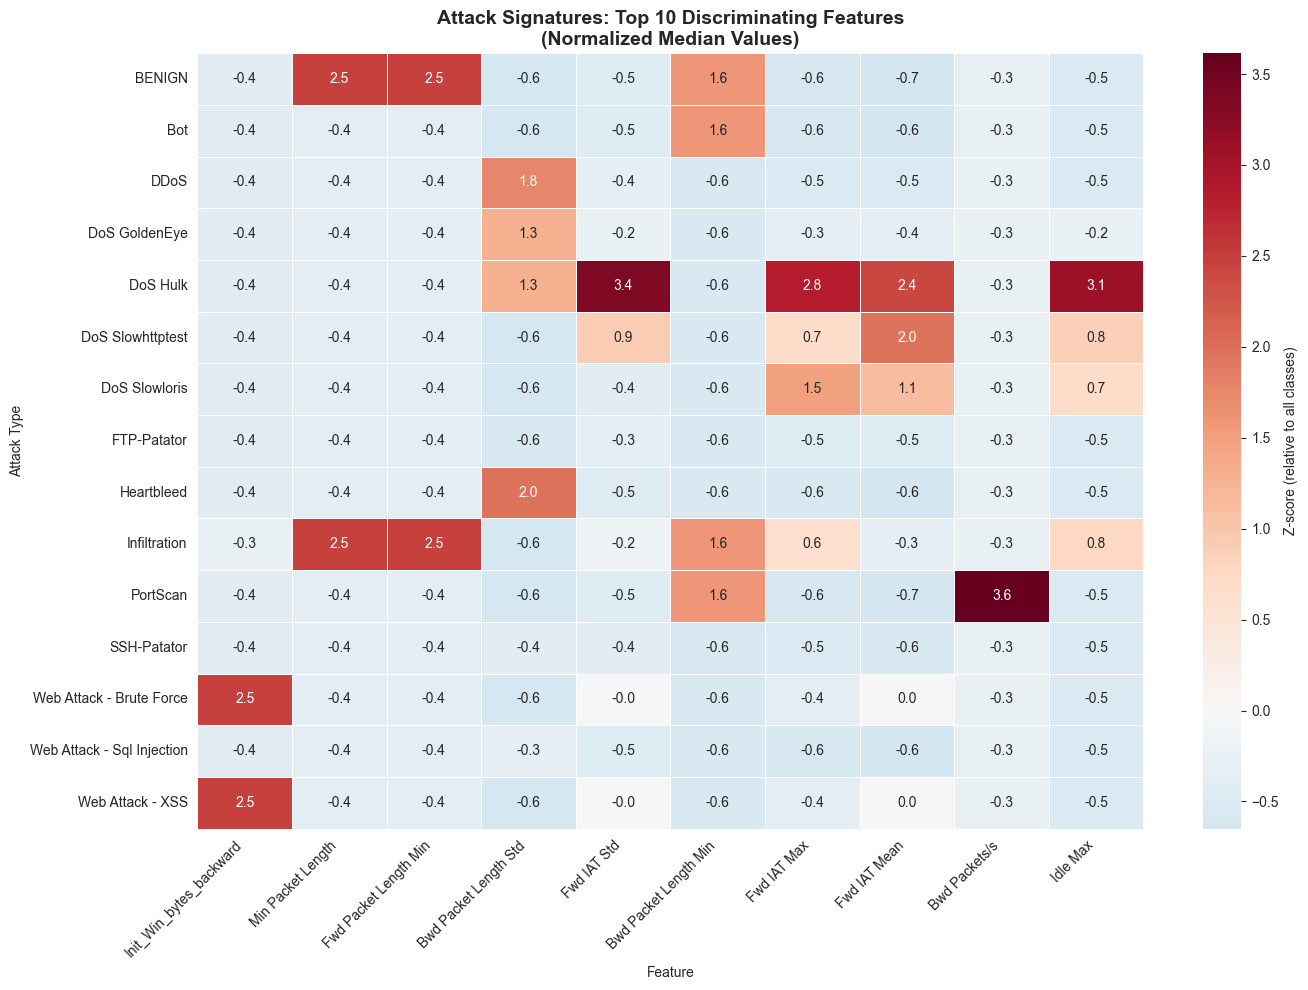

✓ Saved: attack_signatures_heatmap.png


In [17]:
# =============================================================================
# ATTACK SIGNATURE HEATMAP
# =============================================================================

# Create heatmap of normalized signatures
fig, ax = plt.subplots(figsize=(14, 10))

# Sort by attack family for better visualization
label_order = df_signatures_norm.index.tolist()
# Put BENIGN first, then sort attacks
if 'BENIGN' in label_order:
    label_order.remove('BENIGN')
    label_order = ['BENIGN'] + sorted(label_order)

df_plot = df_signatures_norm.loc[label_order]

sns.heatmap(
    df_plot,
    cmap='RdBu_r',
    center=0,
    annot=True,
    fmt='.1f',
    linewidths=0.5,
    ax=ax,
    cbar_kws={'label': 'Z-score (relative to all classes)'}
)

ax.set_title('Attack Signatures: Top 10 Discriminating Features\n(Normalized Median Values)', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Feature')
ax.set_ylabel('Attack Type')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'attack_signatures_heatmap.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Saved: attack_signatures_heatmap.png")

In [18]:
# =============================================================================
# IDENTIFY DISTINCTIVE FEATURES PER ATTACK
# =============================================================================

print("\n--- Most Distinctive Features per Attack Type ---\n")

# For each attack, find features where it differs most from BENIGN
if 'BENIGN' in df_signatures_norm.index:
    benign_sig = df_signatures_norm.loc['BENIGN']
    
    distinctive_features = {}
    
    for label in df_signatures_norm.index:
        if label == 'BENIGN':
            continue
        
        attack_sig = df_signatures_norm.loc[label]
        diff = (attack_sig - benign_sig).abs().sort_values(ascending=False)
        
        # Top 3 most different features
        top_diff = diff.head(3)
        distinctive_features[label] = top_diff.index.tolist()
        
        print(f"{label}:")
        for feat in top_diff.index:
            attack_val = attack_sig[feat]
            benign_val = benign_sig[feat]
            direction = "↑" if attack_val > benign_val else "↓"
            print(f"  {direction} {feat}: z={attack_val:.2f} (BENIGN: {benign_val:.2f})")
        print()


--- Most Distinctive Features per Attack Type ---

Bot:
  ↓ Min Packet Length: z=-0.38 (BENIGN: 2.46)
  ↓ Fwd Packet Length Min: z=-0.38 (BENIGN: 2.46)
  ↑ Fwd IAT Mean: z=-0.64 (BENIGN: -0.65)

FTP-Patator:
  ↓ Min Packet Length: z=-0.38 (BENIGN: 2.46)
  ↓ Fwd Packet Length Min: z=-0.38 (BENIGN: 2.46)
  ↓ Bwd Packet Length Min: z=-0.58 (BENIGN: 1.60)

SSH-Patator:
  ↓ Min Packet Length: z=-0.38 (BENIGN: 2.46)
  ↓ Fwd Packet Length Min: z=-0.38 (BENIGN: 2.46)
  ↓ Bwd Packet Length Min: z=-0.58 (BENIGN: 1.60)

DDoS:
  ↓ Min Packet Length: z=-0.38 (BENIGN: 2.46)
  ↓ Fwd Packet Length Min: z=-0.38 (BENIGN: 2.46)
  ↑ Bwd Packet Length Std: z=1.76 (BENIGN: -0.62)

DoS GoldenEye:
  ↓ Min Packet Length: z=-0.38 (BENIGN: 2.46)
  ↓ Fwd Packet Length Min: z=-0.38 (BENIGN: 2.46)
  ↓ Bwd Packet Length Min: z=-0.58 (BENIGN: 1.60)

DoS Hulk:
  ↑ Fwd IAT Std: z=3.38 (BENIGN: -0.47)
  ↑ Idle Max: z=3.08 (BENIGN: -0.52)
  ↑ Fwd IAT Max: z=2.83 (BENIGN: -0.60)

DoS Slowhttptest:
  ↓ Min Packet Length: 

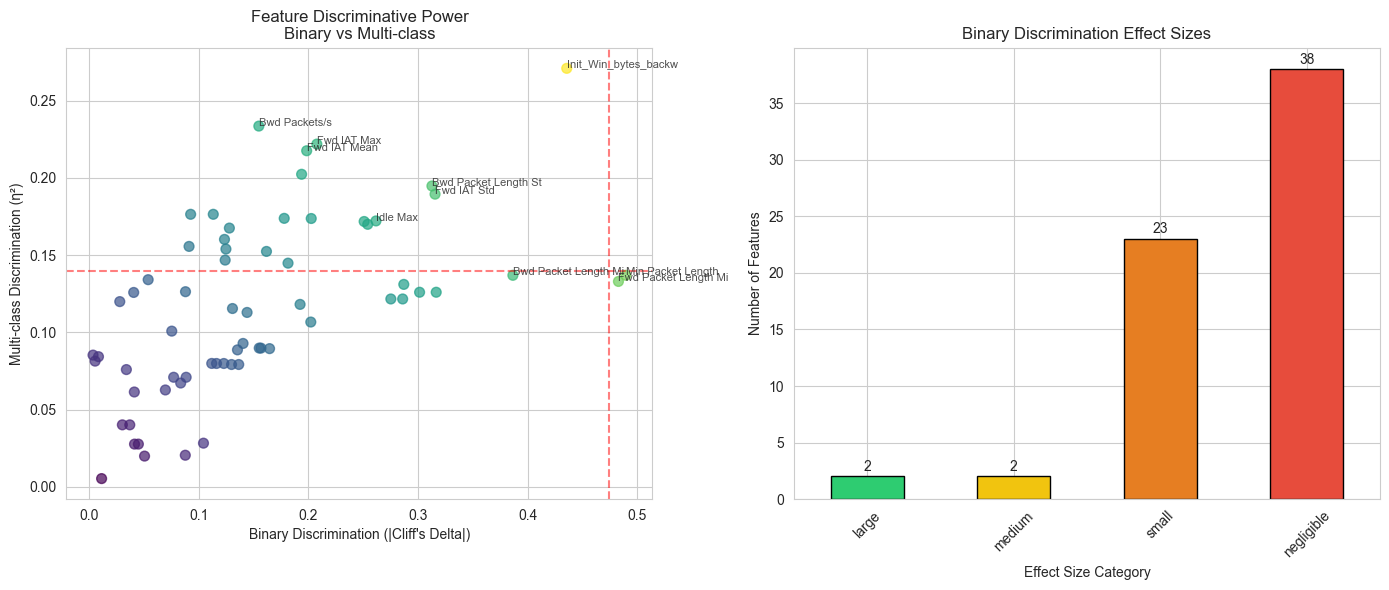

✓ Saved: feature_discrimination.png


In [19]:
# =============================================================================
# FEATURE DISCRIMINATION VISUALIZATION
# =============================================================================

# Scatter plot: Binary vs Multi-class discrimination
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Binary vs Multi-class scatter
ax1 = axes[0]
valid_mask = df_ranking['binary_delta'].notna() & df_ranking['multi_eta'].notna()
plot_data = df_ranking[valid_mask]

ax1.scatter(
    plot_data['binary_delta'],
    plot_data['multi_eta'],
    c=plot_data['combined_score'],
    cmap='viridis',
    s=50,
    alpha=0.7
)

# Label top features
for feat in plot_data.head(10).index:
    row = plot_data.loc[feat]
    ax1.annotate(
        feat[:20],
        (row['binary_delta'], row['multi_eta']),
        fontsize=8,
        alpha=0.8
    )

ax1.set_xlabel("Binary Discrimination (|Cliff's Delta|)")
ax1.set_ylabel("Multi-class Discrimination (η²)")
ax1.set_title("Feature Discriminative Power\nBinary vs Multi-class")
ax1.axhline(y=0.14, color='r', linestyle='--', alpha=0.5, label='Large effect threshold')
ax1.axvline(x=0.474, color='r', linestyle='--', alpha=0.5)

# Right: Effect size distribution
ax2 = axes[1]

# Count effect sizes
effect_counts = df_ranking['binary_effect'].value_counts()
effect_order = ['large', 'medium', 'small', 'negligible', 'insufficient_data']
effect_counts = effect_counts.reindex(effect_order).dropna()

colors = {'large': '#2ecc71', 'medium': '#f1c40f', 'small': '#e67e22', 
          'negligible': '#e74c3c', 'insufficient_data': '#95a5a6'}
bar_colors = [colors.get(e, 'gray') for e in effect_counts.index]

effect_counts.plot(kind='bar', ax=ax2, color=bar_colors, edgecolor='black')
ax2.set_title("Binary Discrimination Effect Sizes")
ax2.set_xlabel("Effect Size Category")
ax2.set_ylabel("Number of Features")
ax2.tick_params(axis='x', rotation=45)

for i, (idx, val) in enumerate(effect_counts.items()):
    ax2.text(i, val + 0.5, str(int(val)), ha='center', fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'feature_discrimination.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Saved: feature_discrimination.png")

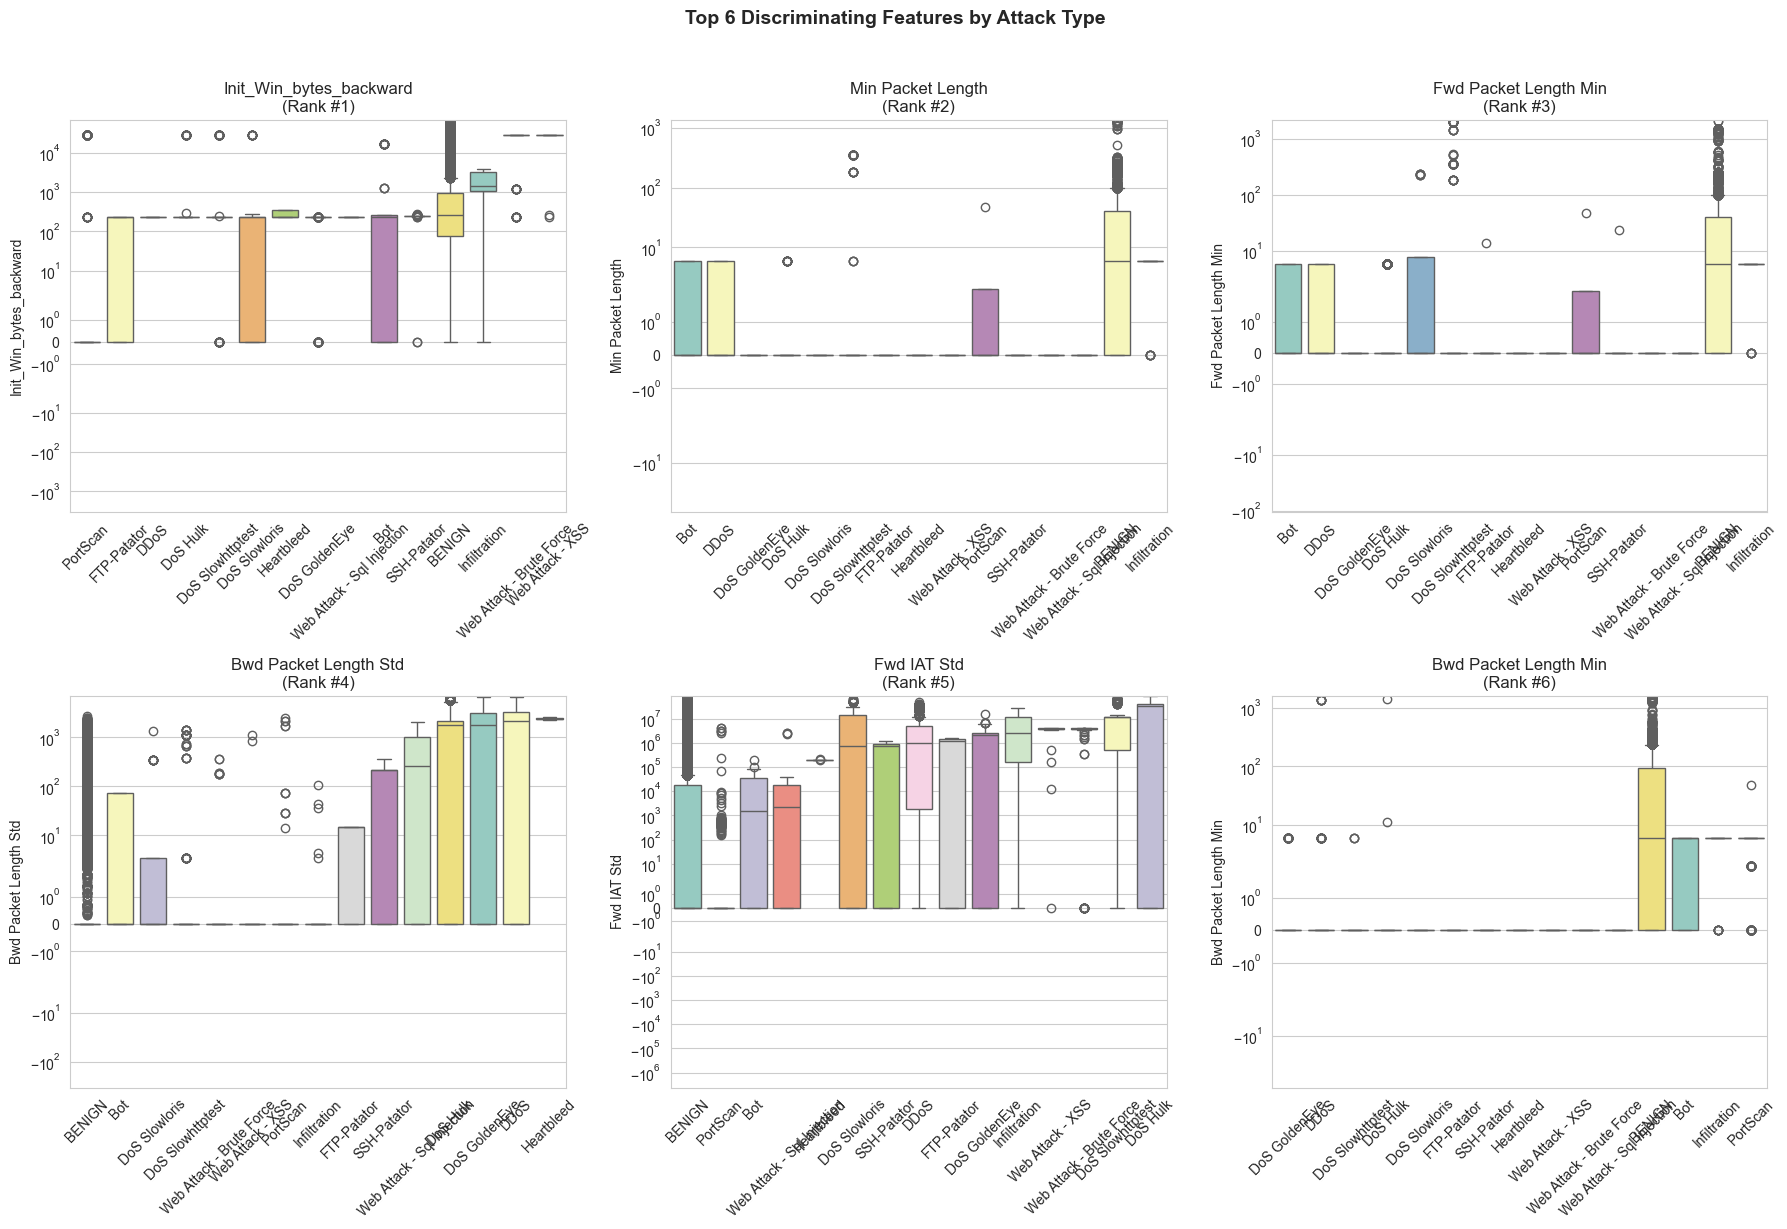

✓ Saved: top_features_boxplots.png


In [20]:
# =============================================================================
# BOXPLOTS: TOP FEATURES BY ATTACK TYPE
# =============================================================================

# Select top 6 features
top_6 = df_ranking.head(6).index.tolist()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, feat in enumerate(top_6):
    ax = axes[i]
    
    # Prepare data
    plot_df = df[[feat, TARGET_COL]].copy()
    plot_df = plot_df.replace([np.inf, -np.inf], np.nan).dropna()
    plot_df = plot_df[plot_df[feat] != -1]  # Exclude sentinel
    
    # Order by median value
    order = plot_df.groupby(TARGET_COL)[feat].median().sort_values().index
    
    # Create boxplot
    sns.boxplot(
        data=plot_df,
        x=TARGET_COL,
        y=feat,
        order=order,
        ax=ax,
        palette='Set3'
    )
    
    ax.set_title(f"{feat}\n(Rank #{i+1})")
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=45)
    
    # Use log scale if range is large
    if plot_df[feat].max() / (plot_df[feat].min() + 1) > 100:
        ax.set_yscale('symlog')

plt.suptitle('Top 6 Discriminating Features by Attack Type', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'top_features_boxplots.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Saved: top_features_boxplots.png")

---
# Phase 4-5 Summary

In [21]:
# =============================================================================
# SAVE ALL RESULTS
# =============================================================================

# Save binary discrimination results
binary_path = os.path.join(OUTPUT_DIR, 'binary_discrimination.csv')
df_binary_disc.to_csv(binary_path)
print(f"✓ Saved: {binary_path}")

# Save multi-class discrimination results
multi_path = os.path.join(OUTPUT_DIR, 'multiclass_discrimination.csv')
df_multi_disc.to_csv(multi_path)
print(f"✓ Saved: {multi_path}")

# Save combined ranking
ranking_path = os.path.join(OUTPUT_DIR, 'feature_ranking.csv')
df_ranking.to_csv(ranking_path)
print(f"✓ Saved: {ranking_path}")

# Save attack signatures
sig_path = os.path.join(OUTPUT_DIR, 'attack_signatures.csv')
df_signatures.to_csv(sig_path)
print(f"✓ Saved: {sig_path}")

# Save target stats as JSON
target_stats = {
    'binary': BINARY_STATS,
    'multiclass': MULTICLASS_STATS,
    'families': FAMILY_STATS,
    'feature_tiers': {
        'top': top_tier,
        'mid': mid_tier,
        'low': low_tier,
    },
    'top_features': df_ranking.head(20).index.tolist(),
}

stats_path = os.path.join(OUTPUT_DIR, 'target_analysis_stats.json')
with open(stats_path, 'w') as f:
    json.dump(target_stats, f, indent=2, default=str)
print(f"✓ Saved: {stats_path}")

✓ Saved: eda_outputs/binary_discrimination.csv
✓ Saved: eda_outputs/multiclass_discrimination.csv
✓ Saved: eda_outputs/feature_ranking.csv
✓ Saved: eda_outputs/attack_signatures.csv
✓ Saved: eda_outputs/target_analysis_stats.json


In [22]:
# =============================================================================
# PHASE 4-5 COMPLETE: SUMMARY
# =============================================================================

print("=" * 70)
print("PHASE 4-5 COMPLETE: TARGET ANALYSIS SUMMARY")
print("=" * 70)

print("\n--- Phase 4: Target Variable ---")
print(f"\nBinary Classification:")
print(f"  BENIGN: {BINARY_STATS['benign_count']:,} ({BINARY_STATS['benign_pct']:.1f}%)")
print(f"  ATTACK: {BINARY_STATS['attack_count']:,} ({BINARY_STATS['attack_pct']:.1f}%)")
print(f"  Imbalance: {BINARY_STATS['imbalance_ratio']:.2f}:1 ({BINARY_STATS['balance_status']})")

print(f"\nMulti-class Classification:")
print(f"  Classes: {MULTICLASS_STATS['n_classes']}")
print(f"  Max/Min ratio: {MULTICLASS_STATS['max_min_ratio']:.1f}:1")
print(f"  Rare classes (<1%): {len(MULTICLASS_STATS['rare_classes'])}")

print(f"\nAttack Families:")
print(f"  Families: {FAMILY_STATS['n_families']}")

print("\n--- Phase 5: Feature-Target Relationships ---")
print(f"\nBinary Discrimination (Mann-Whitney U):")
print(f"  Significant features: {df_binary_disc['significant'].sum()}/{len(numerical_features)}")
print(f"  Large effect size: {(df_binary_disc['effect_size'] == 'large').sum()}")
print(f"  Medium effect size: {(df_binary_disc['effect_size'] == 'medium').sum()}")

print(f"\nMulti-class Discrimination (Kruskal-Wallis H):")
print(f"  Significant features: {df_multi_disc['significant'].sum()}/{len(numerical_features)}")
print(f"  Large effect size (η²≥0.14): {(df_multi_disc['effect_size'] == 'large').sum()}")

print(f"\nFeature Tiers (by combined discriminative power):")
print(f"  Top tier (≥0.5): {len(top_tier)} features")
print(f"  Mid tier (0.2-0.5): {len(mid_tier)} features")
print(f"  Low tier (<0.2): {len(low_tier)} features")

print(f"\n--- Top 10 Most Discriminating Features ---")
for i, feat in enumerate(df_ranking.head(10).index):
    row = df_ranking.loc[feat]
    print(f"  {i+1:2}. {feat}: combined={row['combined_score']:.3f}")

print("\n--- Output Files ---")
output_files = [
    'target_distributions.png',
    'binary_discrimination.csv',
    'multiclass_discrimination.csv',
    'feature_ranking.csv',
    'attack_signatures.csv',
    'attack_signatures_heatmap.png',
    'feature_discrimination.png',
    'top_features_boxplots.png',
    'target_analysis_stats.json',
]

for f in output_files:
    fpath = os.path.join(OUTPUT_DIR, f)
    if os.path.exists(fpath):
        size = os.path.getsize(fpath) / 1024
        print(f"  ✓ {f}: {size:.1f} KB")
    else:
        print(f"  ✗ {f}: not created")

print("\n--- Key Insights ---")
print("""
1. BINARY CLASSIFICATION:
   - Moderately imbalanced but manageable
   - Many features show strong discrimination
   - Standard stratified CV should work well

2. MULTI-CLASS CLASSIFICATION:
   - Highly imbalanced (rare attacks: Heartbleed, Infiltration, Web Attacks)
   - Consider hierarchical: Binary → Family → Specific
   - SMOTE/oversampling needed for rare classes

3. FEATURE SELECTION:
   - Top-tier features are strong candidates for all tasks
   - Mid-tier may add value for specific attack types
   - Low-tier features may be redundant or noise

4. ATTACK SIGNATURES:
   - Different attacks have distinct feature profiles
   - DoS attacks show different patterns than Brute Force
   - Feature engineering could exploit these patterns
""")

print("\n--- Next Steps ---")
print("  → Notebook 04: Correlation Analysis + Phase 7 Semantic Deep-Dive")
print("  → Focus on: sentinel value patterns by attack, infinite value causes")

print("\n" + "=" * 70)
print(f"Completed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 70)

PHASE 4-5 COMPLETE: TARGET ANALYSIS SUMMARY

--- Phase 4: Target Variable ---

Binary Classification:
  BENIGN: 227,311 (80.3%)
  ATTACK: 55,827 (19.7%)
  Imbalance: 4.07:1 (Moderately imbalanced)

Multi-class Classification:
  Classes: 15
  Max/Min ratio: 20664.6:1
  Rare classes (<1%): 11

Attack Families:
  Families: 8

--- Phase 5: Feature-Target Relationships ---

Binary Discrimination (Mann-Whitney U):
  Significant features: 65/65
  Large effect size: 2
  Medium effect size: 2

Multi-class Discrimination (Kruskal-Wallis H):
  Significant features: 65/65
  Large effect size (η²≥0.14): 21

Feature Tiers (by combined discriminative power):
  Top tier (≥0.5): 20 features
  Mid tier (0.2-0.5): 31 features
  Low tier (<0.2): 14 features

--- Top 10 Most Discriminating Features ---
   1. Init_Win_bytes_backward: combined=0.945
   2. Min Packet Length: combined=0.753
   3. Fwd Packet Length Min: combined=0.739
   4. Bwd Packet Length Std: combined=0.679
   5. Fwd IAT Std: combined=0.672